# Assignment: Data Wrangling
### `! git clone https://github.com/ds3001f25/wrangling_assignment.git`
### Do Q1 and Q2
### Reading material: `tidy_data.pdf`

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `./data/airbnb_hw.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `./data/mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Is this a concern? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing?
3. Dummy variable: For the pretrial data covered in the lecture `./data/justice_data.parquet`, clean the `WhetherDefendantWasReleasedPretrial` variable as well as you can, and, in particular, replace missing values with `np.nan`.
4. Missing values, not at random: For the pretrial data covered in the lecture, clean the `ImposedSentenceAllChargeInContactEvent` variable as well as you can, and explain the choices you make. (Hint: Look at the `SentenceTypeAllChargesAtConvictionInContactEvent` variable.)

In [5]:
# Q1 — Full Python solution with file finder
# Works in Colab or local Jupyter

import os, glob, re
import numpy as np
import pandas as pd

# ---------------------------
# 0) File finder utility
# ---------------------------
def find_one(filename):
    hits = glob.glob(f'**/{filename}', recursive=True)
    if not hits:
        raise FileNotFoundError(f"Could not find {filename}. "
                                f"Upload it or place it in a folder (e.g., ./data/).")
    print(f"Using {filename} at: {hits[0]}")
    return hits[0]

AIRBNB_PATH = find_one('airbnb_hw.csv')
POLICE_PATH = find_one('mn_police_use_of_force.csv')
JUSTICE_PATH = find_one('justice-data.csv')  # <-- use the CSV you converted from parquet

# ---------------------------
# 1) Load data
# ---------------------------
airbnb = pd.read_csv(AIRBNB_PATH, low_memory=False)
police  = pd.read_csv(POLICE_PATH, low_memory=False)
justice = pd.read_csv(JUSTICE_PATH, low_memory=False)

print("Loaded shapes:")
print("  airbnb:", airbnb.shape)
print("  police:", police.shape)
print("  justice:", justice.shape)

# ============================================================
# Q1.1 Numeric variable (Airbnb) — clean Price and count NAs
# ============================================================
_price_pat = re.compile(r"[-]?\d[\d,]*\.?\d*")

def parse_price(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    hits = _price_pat.findall(s)
    if not hits:
        return np.nan
    num = hits[-1].replace(",", "")
    try:
        return float(num)
    except:
        return np.nan

if "Price" not in airbnb.columns:
    raise KeyError("Expected 'Price' column in airbnb_hw.csv")

airbnb["Price_clean"] = airbnb["Price"].apply(parse_price)
n_missing_after = airbnb["Price_clean"].isna().sum()
n_rows = len(airbnb)

print("\nQ1.1 — Airbnb Price cleaning")
print("----------------------------")
print(airbnb[["Price", "Price_clean"]].head(8))
print(f"Rows: {n_rows:,}")
print(f"Missing Price_clean: {n_missing_after:,} ({n_missing_after/n_rows:.2%})")

# ============================================================
# Q1.2 Categorical variable (Police) — subject_injury cleaned
# ============================================================
def norm_injury(x):
    if pd.isna(x):
        return "No"
    s = str(x).strip().lower()
    yes_tokens = {"yes", "y", "injury", "injured", "true", "1"}
    no_tokens  = {"no", "n", "none", "false", "0"}
    if s in yes_tokens:
        return "Yes"
    if s in no_tokens:
        return "No"
    return "No"

lower2actual = {c.lower(): c for c in police.columns}
subject_col = lower2actual.get("subject_injury")
force_col   = lower2actual.get("force_type")

if subject_col is None or force_col is None:
    raise KeyError("Could not find subject_injury / force_type columns in police data")

police["subject_injury_clean"] = police[subject_col].apply(norm_injury)
prop_yes = (police["subject_injury_clean"] == "Yes").mean()
ct = pd.crosstab(police["subject_injury_clean"], police[force_col], normalize="index").round(3)

print("\nQ1.2 — Police 'subject_injury'")
print("-------------------------------")
print(f"Proportion injured: {prop_yes:.3f}")
print("Cross-tab (row-normalized):")
print(ct)

# ============================================================
# Q1.3 Dummy variable (Justice) — ReleasedPretrial
# ============================================================
cand_names = [c for c in justice.columns if c.lower() == "whetherdefendantwasreleasedpretrial".lower()]
if not cand_names:
    cand_names = [c for c in justice.columns if "released" in c.lower() and "pretrial" in c.lower()]
if not cand_names:
    raise KeyError("Could not find ReleasedPretrial column")
released_col = cand_names[0]

def to_dummy(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    if s in {"yes","y","true","1"}: return 1
    if s in {"no","n","false","0"}: return 0
    return np.nan

justice["ReleasedPretrial_dummy"] = justice[released_col].apply(to_dummy)

print("\nQ1.3 — ReleasedPretrial dummy")
print("-----------------------------")
print(justice[[released_col, "ReleasedPretrial_dummy"]].head(8))
print(justice["ReleasedPretrial_dummy"].value_counts(dropna=False))

# ============================================================
# Q1.4 Missing values not at random (Justice sentencing)
# ============================================================
possible_targets = [
    "ImposedSentenceAllChargeInContactEvent",
    "SentenceTypeAllChargesAtConvictionInContactEvent",
]
target_col = None
lower_cols = {c.lower(): c for c in justice.columns}
for name in possible_targets:
    if name.lower() in lower_cols:
        target_col = lower_cols[name.lower()]
        break
if target_col is None:
    for c in justice.columns:
        cl = c.lower()
        if "sentence" in cl and "contactevent" in cl:
            target_col = c
            break

if target_col is None:
    raise KeyError("Could not find sentencing column")

missing_rate = justice[target_col].isna().mean()
justice["Sentencing_missing_flag"] = justice[target_col].isna().astype(int)

print("\nQ1.4 — Sentencing missingness")
print("------------------------------")
print(f"Target column: {target_col}")
print(f"Missing rate: {missing_rate:.3f}")
print(justice[[target_col, "Sentencing_missing_flag"]].head(10))




Using airbnb_hw.csv at: airbnb_hw.csv
Using mn_police_use_of_force.csv at: mn_police_use_of_force.csv
Using justice-data.csv at: justice-data.csv
Loaded shapes:
  airbnb: (30478, 13)
  police: (12925, 13)
  justice: (22986, 709)

Q1.1 — Airbnb Price cleaning
----------------------------
  Price  Price_clean
0   145        145.0
1    37         37.0
2    28         28.0
3   199        199.0
4   549        549.0
5   149        149.0
6   250        250.0
7    90         90.0
Rows: 30,478
Missing Price_clean: 0 (0.00%)

Q1.2 — Police 'subject_injury'
-------------------------------
Proportion injured: 0.126
Cross-tab (row-normalized):
force_type            Baton  Bodily Force  Chemical Irritant  Firearm  \
subject_injury_clean                                                    
No                    0.000         0.721              0.137      0.0   
Yes                   0.001         0.788              0.025      0.0   

force_type            Gun Point Display  Improvised Weapon  Less Let

**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks (Hint: `GSAF5.xls`).

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work.
2. Drop any columns that do not contain data.
3. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
4. Clean the Age variable and make a histogram of the ages of the victims.
5. What proportion of victims are male?
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Are sharks more likely to launch unprovoked attacks on men or women? Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Is it more or less likely to be fatal when the victim is male or female? How do you feel about sharks?
9. What proportion of attacks appear to be by white sharks? (Hint: `str.split()` makes a vector of text values into a list of lists, split by spaces.)

Using GSAF5.xls at: GSAF5.xls
Raw shape: (7042, 23)
After dropping empty columns: (7042, 23)
Detected columns:
Year   -> Year
Date   -> Date
Age    -> Age
Sex    -> Sex
Type   -> Type
Fatal  -> None
Species-> Species 

Year range (raw cleaned): 1500–2026
Rows since 1940: 5507

Counts by decade since 1940:
   decade  count
0  1940.0    283
1  1950.0    467
2  1960.0    618
3  1970.0    339
4  1980.0    438
5  1990.0    572
6  2000.0   1022
7  2010.0   1249
8  2020.0    519

Age summary (since 1940):
count    3690.000000
mean       28.587805
std        14.779467
min         1.000000
25%        17.000000
50%        25.000000
75%        37.000000
max        87.000000
Name: Age_clean, dtype: float64


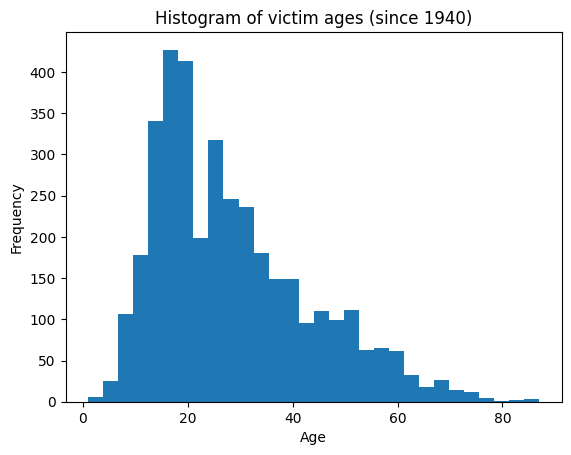


Proportion of known-sex victims who are male: 0.858 (n=5053)

Type value counts (cleaned):
Type_clean
Unprovoked    4098
Unknown        889
Provoked       520
Name: count, dtype: int64
Proportion Unprovoked (all rows): 0.744

Fatal Y/N counts (cleaned):
Fatal_clean
Unknown    5507
Name: count, dtype: int64

P(Unprovoked | Sex):
Sex_clean
F    0.851389
M    0.771521
Name: P(Unprovoked), dtype: float64

P(Fatal | Type_clean):
Series([], Name: P(Fatal), dtype: object)

P(Fatal | Sex):
Series([], Name: P(Fatal), dtype: object)

Proportion of attacks that appear to be by white sharks: 0.129

Saved: shark_clean.csv (since 1940 with cleaned fields)


In [6]:
# Q2 — Shark attack analysis (GSAF5.xls)
# Works in Colab. Requires the file to be uploaded in the workspace.

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 0) Find the Excel file
# ---------------------------
def find_one(filename):
    hits = glob.glob(f'**/{filename}', recursive=True)
    if not hits:
        raise FileNotFoundError(f"Could not find {filename}. Upload it (left panel → folder → upload).")
    print(f"Using {filename} at: {hits[0]}")
    return hits[0]

GSAF_PATH = find_one('GSAF5.xls')

# ---------------------------
# 1) Load + drop empty columns
# ---------------------------
# Most GSAF5 distributions keep the first sheet as the main table.
# Pandas will pick a suitable engine for .xls automatically (xlrd).
df_raw = pd.read_excel(GSAF_PATH)
print("Raw shape:", df_raw.shape)

# Drop columns that are entirely empty
df = df_raw.dropna(axis=1, how='all').copy()
print("After dropping empty columns:", df.shape)

# Helper: case-insensitive column locator
def find_col(df, key):
    # exact match first
    for c in df.columns:
        if c.strip().lower() == key.strip().lower():
            return c
    # contains match
    for c in df.columns:
        if key.strip().lower() in c.strip().lower():
            return c
    return None

# Likely column names in GSAF
col_year     = find_col(df, "Year")
col_date     = find_col(df, "Date")
col_age      = find_col(df, "Age")
col_sex      = find_col(df, "Sex")
col_type     = find_col(df, "Type")
col_fatal    = find_col(df, "Fatal (Y/N)")
col_species  = find_col(df, "Species")

print("Detected columns:")
print("Year   ->", col_year)
print("Date   ->", col_date)
print("Age    ->", col_age)
print("Sex    ->", col_sex)
print("Type   ->", col_type)
print("Fatal  ->", col_fatal)
print("Species->", col_species)

# ---------------------------
# 2) Clean Year (Q2.3 first part + filter since 1940)
# ---------------------------
def to_year(val):
    if pd.isna(val):
        return np.nan
    # Prefer 4-digit numbers
    s = str(val)
    # sometimes already numeric
    try:
        y = int(float(s))
        if 1500 <= y <= 2100:
            return y
    except:
        pass
    m = re.search(r'(\d{4})', s)
    if m:
        y = int(m.group(1))
        if 1500 <= y <= 2100:
            return y
    return np.nan

# If no Year column, extract from Date
if col_year is None and col_date is not None:
    df["Year_clean"] = df[col_date].apply(to_year)
else:
    df["Year_clean"] = df[col_year].apply(to_year) if col_year else np.nan

year_min, year_max = int(np.nanmin(df["Year_clean"])), int(np.nanmax(df["Year_clean"]))
print(f"\nYear range (raw cleaned): {year_min}–{year_max}")

# Focus since 1940
df_recent = df.loc[df["Year_clean"] >= 1940].copy()
print("Rows since 1940:", df_recent.shape[0])

# Are attacks increasing over time? Count by decade and by year
by_year = df_recent.groupby("Year_clean").size().rename("count").reset_index()
by_decade = df_recent.assign(decade=(df_recent["Year_clean"]//10)*10)\
                     .groupby("decade").size().rename("count").reset_index()

print("\nCounts by decade since 1940:")
print(by_decade)

# ---------------------------
# 3) Clean Age & histogram (Q2.4)
# ---------------------------
def to_age(val):
    if pd.isna(val):
        return np.nan
    s = str(val).lower().strip()
    # common forms like 'teen', 'adult', '20s' → we won't coerce unless numeric present
    m = re.search(r'(\d+(\.\d+)?)', s)
    if not m:
        return np.nan
    try:
        a = float(m.group(1))
        # sanity bounds: human ages
        if 0 <= a <= 120:
            return a
    except:
        pass
    return np.nan

if col_age:
    df_recent["Age_clean"] = df_recent[col_age].apply(to_age)
else:
    df_recent["Age_clean"] = np.nan

print("\nAge summary (since 1940):")
print(df_recent["Age_clean"].describe())

# Histogram
plt.figure()
df_recent["Age_clean"].dropna().plot(kind="hist", bins=30)
plt.title("Histogram of victim ages (since 1940)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# ---------------------------
# 4) Proportion male (Q2.5)
# ---------------------------
def clean_sex(x):
    if pd.isna(x): return "Unknown"
    s = str(x).strip().upper()
    if s in {"M","MALE"}: return "M"
    if s in {"F","FEMALE"}: return "F"
    return "Unknown"

if col_sex:
    df_recent["Sex_clean"] = df_recent[col_sex].apply(clean_sex)
else:
    df_recent["Sex_clean"] = "Unknown"

known_sex = df_recent.loc[df_recent["Sex_clean"].isin(["M","F"])]
prop_male = (known_sex["Sex_clean"] == "M").mean()
print(f"\nProportion of known-sex victims who are male: {prop_male:.3f} (n={len(known_sex)})")

# ---------------------------
# 5) Clean Type to {Unprovoked, Provoked, Unknown} (Q2.6)
# ---------------------------
def clean_type(x):
    if pd.isna(x): return "Unknown"
    s = str(x).lower()
    if "unprovoked" in s: return "Unprovoked"
    if "provoked" in s:   return "Provoked"
    # Map a few common labels to Unknown (boat, sea disaster, invalid, etc.)
    return "Unknown"

if col_type:
    df_recent["Type_clean"] = df_recent[col_type].apply(clean_type)
else:
    df_recent["Type_clean"] = "Unknown"

type_counts = df_recent["Type_clean"].value_counts(dropna=False)
prop_unprov = (df_recent["Type_clean"] == "Unprovoked").mean()
print("\nType value counts (cleaned):")
print(type_counts)
print(f"Proportion Unprovoked (all rows): {prop_unprov:.3f}")

# ---------------------------
# 6) Clean Fatal Y/N to {Y, N, Unknown} (Q2.7)
# ---------------------------
def clean_fatal(x):
    if pd.isna(x): return "Unknown"
    s = str(x).strip().upper()
    if s.startswith("Y"): return "Y"
    if s.startswith("N"): return "N"
    return "Unknown"

if col_fatal:
    df_recent["Fatal_clean"] = df_recent[col_fatal].apply(clean_fatal)
else:
    df_recent["Fatal_clean"] = "Unknown"

print("\nFatal Y/N counts (cleaned):")
print(df_recent["Fatal_clean"].value_counts(dropna=False))

# ---------------------------
# 7) Q2.8 — Unprovoked vs sex; fatality vs sex & type
# ---------------------------
# Are sharks more likely to launch unprovoked attacks on men or women?
unprov_by_sex = (df_recent
                 .loc[df_recent["Sex_clean"].isin(["M","F"])]
                 .groupby("Sex_clean")["Type_clean"]
                 .apply(lambda s: (s=="Unprovoked").mean())
                 .rename("P(Unprovoked)"))
print("\nP(Unprovoked | Sex):")
print(unprov_by_sex)

# Is attack more or less likely to be fatal when attack is provoked or unprovoked?
fatal_by_type = (df_recent
                 .loc[df_recent["Fatal_clean"].isin(["Y","N"])]
                 .groupby("Type_clean")["Fatal_clean"]
                 .apply(lambda s: (s=="Y").mean())
                 .rename("P(Fatal)"))
print("\nP(Fatal | Type_clean):")
print(fatal_by_type)

# Is it more/less likely to be fatal when the victim is male or female?
fatal_by_sex = (df_recent
                .loc[df_recent["Fatal_clean"].isin(["Y","N"]) & df_recent["Sex_clean"].isin(["M","F"])]
                .groupby("Sex_clean")["Fatal_clean"]
                .apply(lambda s: (s=="Y").mean())
                .rename("P(Fatal)"))
print("\nP(Fatal | Sex):")
print(fatal_by_sex)

# ---------------------------
# 8) Q2.9 — Proportion that appear to be by white sharks
# ---------------------------
def is_white_shark(x):
    if pd.isna(x): return False
    return "white" in str(x).lower()

if col_species:
    df_recent["WhiteShark_flag"] = df_recent[col_species].apply(is_white_shark)
else:
    df_recent["WhiteShark_flag"] = False

prop_white = df_recent["WhiteShark_flag"].mean()
print(f"\nProportion of attacks that appear to be by white sharks: {prop_white:.3f}")

# ---------------------------
# 9) Save a clean subset for your write-up
# ---------------------------
keep_cols = {
    col_year or "Year", col_date or "Date", col_age or "Age", col_sex or "Sex",
    col_type or "Type", col_fatal or "Fatal (Y/N)", col_species or "Species"
}
keep_cols = [c for c in keep_cols if c in df.columns]

out = df_recent.assign(
    Year=df_recent["Year_clean"],
    Age=df_recent["Age_clean"],
    Sex=df_recent["Sex_clean"],
    Type=df_recent["Type_clean"],
    Fatal=df_recent["Fatal_clean"],
    WhiteShark=df_recent["WhiteShark_flag"]
)[["Year","Age","Sex","Type","Fatal","WhiteShark"] + keep_cols].copy()

out.to_csv("shark_clean.csv", index=False)
print("\nSaved: shark_clean.csv (since 1940 with cleaned fields)")
